# Conformal Prediction

The degree of confidence a model influenced with the sparsity of observed instances. Conformal prediction can improve the prediction accuracy by adding a calibration process on top of any model to take the quantified uncertainty into account.

To carry out conformal prediction, dataset has to be splitted into three disjoint sets for training, calibration and validation respectively. An initial prediction interval is created with the the base quantile regression model trained by the training dataset. Target variables in the calibration set are being compared to the predicted value, which is denoted as the quantified uncertainty. The final conformal prediction interval is then formed by adding the averaged differences to both tails of the predicted value.

You might select *Naive* (`naive`) or *Conformalised Quantile Regression* (`cqr`) for the conformal prediction in NeuralProphet. Here, we illustrate and further elaborate on the two models of conformal prediction using the hospital electric load dataset. The dataset has recorded the electricity consumption of a hospital in SF in 2015 by hour.

In [1]:
# much faster using the following code, but may not have the latest upgrades/bugfixes
# !pip install neuralprophet  

if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git  # may take a while

In [2]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "energy/SF_hospital_load.csv")

### Data spliting

First, we would be dividing the dataset into three subset using the data spliting function in NeuralProphet. You can configure the function by indicating the time series frequencies and splitting ratio. List of frequency aliases can be find <a href= 'https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases'>here</a>.

In our hospital electric load dataset, we will first divide the original dataset into training and testing set with a train-test ration of 0.9.


In [8]:
# Create NeuralProphet object 
m = NeuralProphet()

# Data spliting function split one timeseries dataframe into two
# Configure the hourly frequency by assigning 'H' to parameter freq
# Configure the splitting ratio with a value between 0 and 1 for valid_p
train_df, test_df = m.split_df(df, freq="H", valid_p=0.1)
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0 / 11)


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_

In [9]:
train_df.shape, cal_df.shape, test_df.shape

((6452, 2), (716, 2), (716, 2), (876, 2))

In [5]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-09-26 20:00:00
Validation set time range:   2015-09-26 21:00:00 - 2015-10-26 16:00:00
Calibration set time range:  2015-10-26 17:00:00 - 2015-11-25 12:00:00
Test set time range:         2015-11-25 13:00:00 - 2016-01-01 00:00:00


### Base model training
You can build any NeuralProphet model you deemed as fit as the base model. The calibration process in conformal prediction would later added on the base model to quantify the uncertainty in our final estimation.

Back to our example, assuming we want to build an autoregression NeuralProphet model which can be providing us a prediction interval with 90% of confidence level. You can refer to the `Tutorials`, `Autoregression` and `Uncertainty Estimation with Quantile Regression` standalone tutorial sessions for the logic and applications of the features.


In [10]:
#Parameter for autoregression
n_lags = 3 * 24

#Parameter for quantile regression
confidence_lv = 0.9  
quantile_list = [(1 - confidence_lv) / 2, confidence_lv + (1 - confidence_lv) / 2]



m1 = NeuralProphet(
    quantiles=quantiles,
)

#Create a 4-layer autoregression model as the base
m2 = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantile
)

Train the 4 models. You can either concatonate the train and val set into one full training set or use the val set separately for hyperparameter tuning. I recommend trying both ways to see how to performance evaluation metrics change.

In [18]:
%%time
random_seed = 0

# Conconate train_df and val_df as full training set
set_random_seed(random_seed)
metrics1 = m1.fit(pd.concat([train_df, val_df]), freq="H")
metrics2 = m2.fit(pd.concat([train_df, val_df]), freq="H")


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (234) is too small than the required number for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (234) is too small than the required number for the learning rate finder (246). The results might not be optimal.


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (232) is too small than the required number for the learning rate finder (246). The results might not be optimal.


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (232) is too small than the required number for the learning rate finder (246). The results might not be optimal.


Training: 0it [00:00, ?it/s]

CPU times: user 10min 9s, sys: 1.56 s, total: 10min 11s
Wall time: 15min 19s


In [22]:
metrics4.tail(1)

,MAE,RMSE,Loss,RegLoss,epoch
110,7.063153,10.06792,0.000155,0.0,110


**Get forecasts of out-of-sample (OOS) test_df**

In [23]:
forecast1 = m1.predict(test_df)[n_lags:]
forecast2 = m2.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


**Plot QR forecasts with OOS test_df**

In [28]:
cutoff = 7 * 24  # 0
x_size = 10
y_size = 5
figsize = (x_size, y_size)
plotting_backend = "default"

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Sw

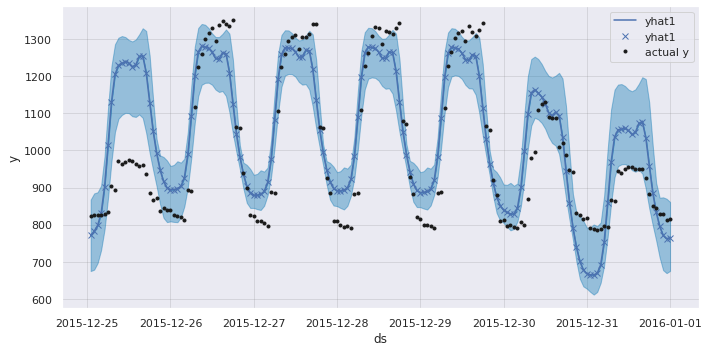

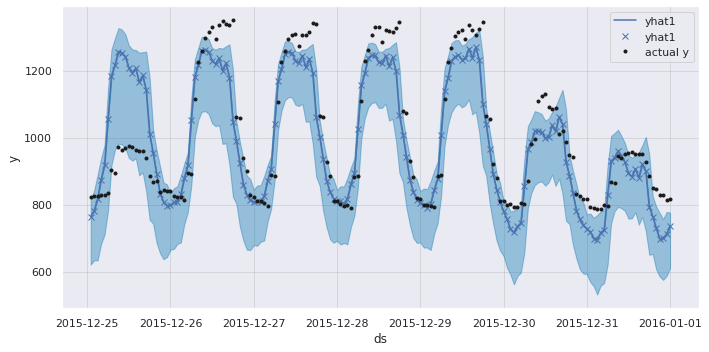

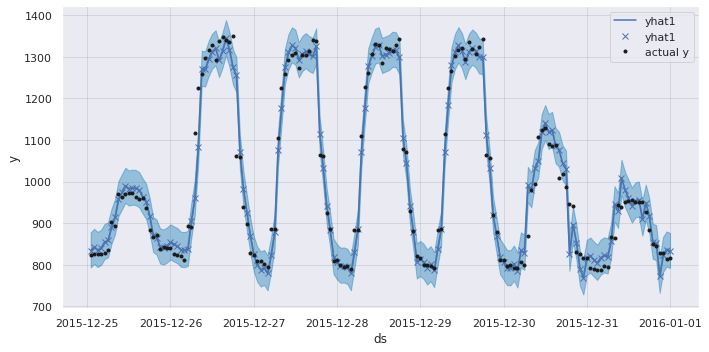

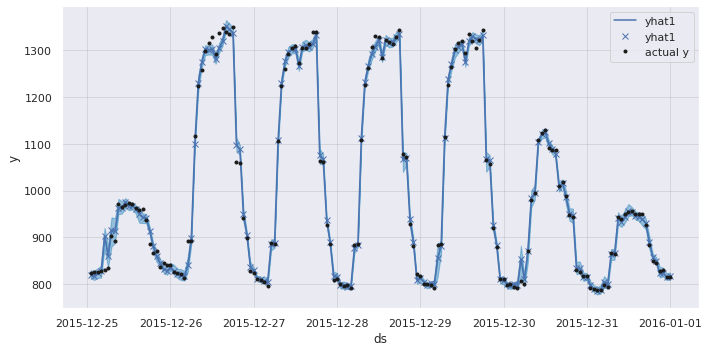

In [29]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

### Conformal predict and plot

**Naive**

In [30]:
method = "naive"
alpha = 0.1
plotting_backend = "matplotlib"  # "plotly", None

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


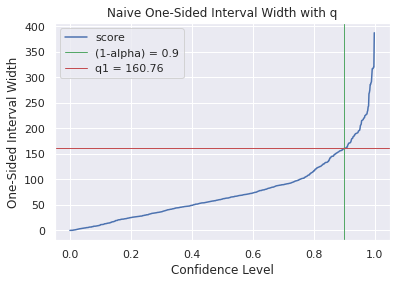

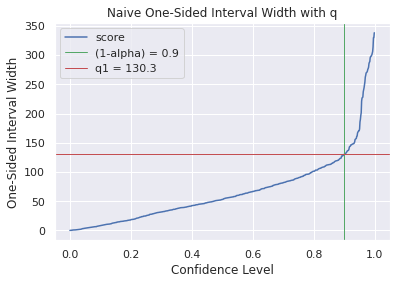

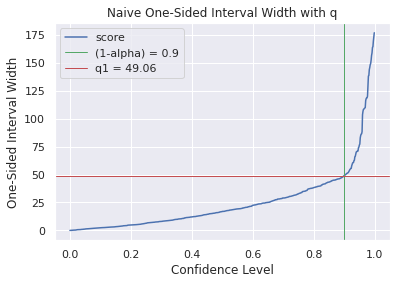

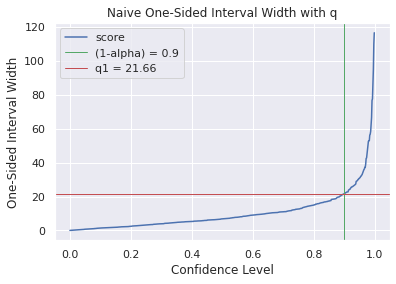

In [31]:
naive_forecast1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)
naive_forecast2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)
naive_forecast3 = m3.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)
naive_forecast4 = m4.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)

The plots above (m1 to m4) show the one-sided prediction interval width for a given confidence level. This one-sided prediction interval width is the `q` value from the sorted *nonconformity scores* from the Naive conformal prediction method. More specifically, this `q` value is the *nonconformity score* at the confidence level of 1 - `alpha`, or in this case 1 - 0.1 = 0.9. Finally, `q` is added on and subtracted from predicted value`y-hat` to form the full prediction interval. Hence `q` is also known as `q-hat`.

Below are the `q-hat` values models m1 - m4:

In [32]:
naive_qhat1 = naive_forecast1.iloc[0]["qhat1"]
naive_qhat2 = naive_forecast2.iloc[0]["qhat1"]
naive_qhat3 = naive_forecast3.iloc[0]["qhat1"]
naive_qhat4 = naive_forecast4.iloc[0]["qhat1"]

naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4

(160.75530026875003, 130.30437253437503, 49.055130528125005, 21.65865092343745)

Get forecasts and *naive* conformal prediction interval of OOS test_df

In [33]:
naive_forecast1 = naive_forecast1[n_lags:]
naive_forecast2 = naive_forecast2[n_lags:]
naive_forecast3 = naive_forecast3[n_lags:]
naive_forecast4 = naive_forecast4[n_lags:]

Plot QR forecasts and *naive* conformal prediction intervals with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Sw

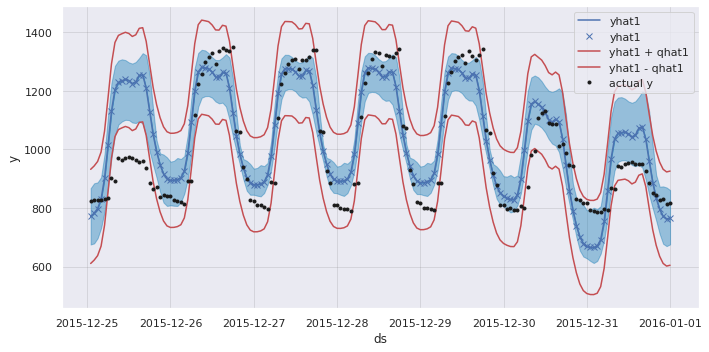

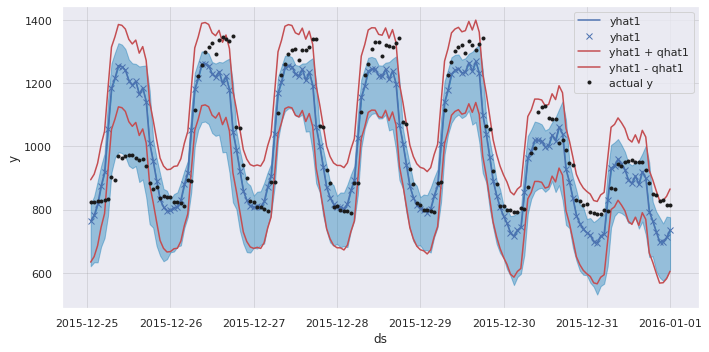

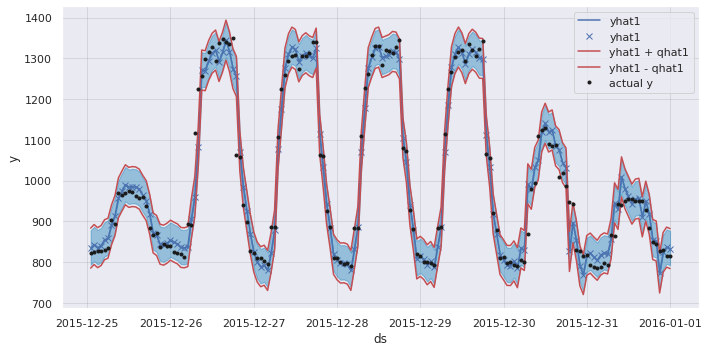

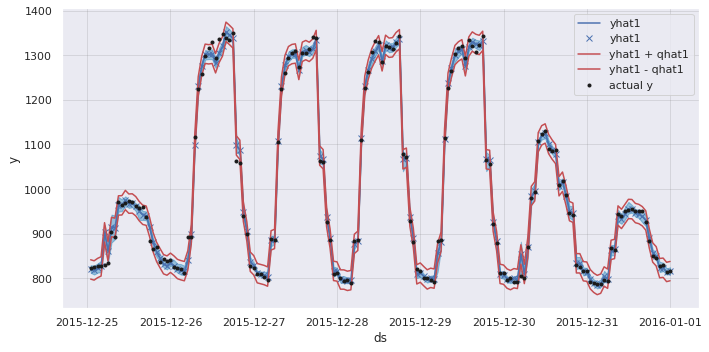

In [38]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

**CQR**

Conformal prediction can be used to improve the prediction accuracy of the quantile regression model with an extra calibration process, especially for dataset with small sample size. You can refer to the `Uncertainty Estimation with Quantile Regression` tutorial session for more detailed information regarding the quantile regression model.

Target variables in the calibration set are being compared to the nearest quantile. Difference between each pair of true and predicted values is recorded as an element in a list, which would be a positive integer if the true value lays outside the predicted interval and vice versa. The initial interval is then adjusted in accordance to quantile value computed with the aforementioned list and your desired quantile.

In [39]:
method = "cqr"
alpha = 0.1
plotting_backend = "matplotlib"  # "plotly", None

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


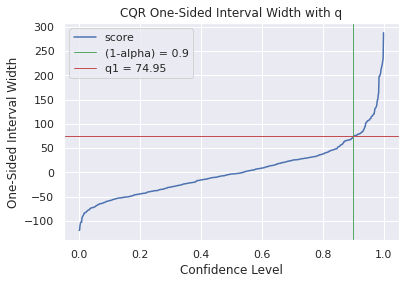

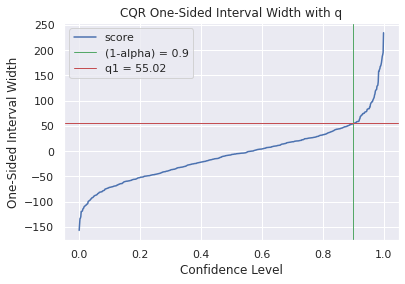

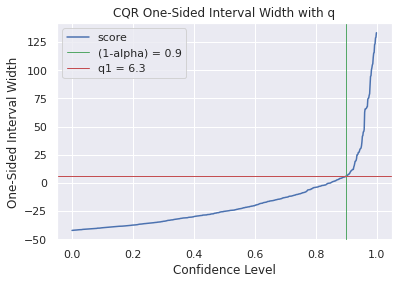

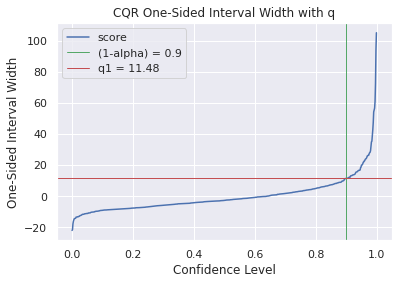

In [40]:
cqr_forecast1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)
cqr_forecast2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)
cqr_forecast3 = m3.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)
cqr_forecast4 = m4.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend=plotting_backend,
)

The plots above (m1 to m4) show the one-sided prediction interval width for a given confidence level. This one-sided prediction interval width is the `q` value from the sorted *nonconformity scores* from the CQR conformal prediction method. Unlike the Naive method, however, the CQR adjusts the prediction interval width of the existing quantile regression (QR).
- If the one-sided prediction interval width is **positive**, then CQR **extends** beyond the QR intervals, as it deems the QR interval to be too **confident**.
- Conversely, if the one-sided prediction interval width is **negative**, then CQR **contracts** the QR intervals, as it deems the QR interval to be too **conservative**.

Below are the `q-hat` values models m1 - m4. As they are all positive, you will see the CQR interval extending beyond that of QR. Model m1 has a large gap between these two intervals, while for m3, they are practically touching.  

In [41]:
cqr_qhat1 = cqr_forecast1.iloc[0]["qhat1"]
cqr_qhat2 = cqr_forecast2.iloc[0]["qhat1"]
cqr_qhat3 = cqr_forecast3.iloc[0]["qhat1"]
cqr_qhat4 = cqr_forecast4.iloc[0]["qhat1"]

cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(74.94919968203124, 55.019333671875074, 6.295553921874898, 11.481231328906233)

Get forecasts and *CQR* conformal prediction interval of OOS test_df

In [42]:
cqr_forecast1 = cqr_forecast1[n_lags:]
cqr_forecast2 = cqr_forecast2[n_lags:]
cqr_forecast3 = cqr_forecast3[n_lags:]
cqr_forecast4 = cqr_forecast4[n_lags:]

In [43]:
cqr_forecast1.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,qhat1,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,1087.088623,972.237061,1165.704346,1032.707031,61.734299,-7.352807,74.9492,1090.755146,1240.653545,897.287861,1047.186260
73,2015-12-12 07:00:00,1102.066076,1194.688843,1066.541138,1272.411499,1032.724121,60.781769,101.183006,74.9492,1197.462299,1347.360699,991.591938,1141.490337
74,2015-12-12 08:00:00,1214.971839,1259.173584,1139.253418,1323.115479,1032.741089,59.720352,166.712158,74.9492,1248.166279,1398.064678,1064.304218,1214.202618
75,2015-12-12 09:00:00,1257.597327,1274.854980,1169.967651,1333.975098,1032.758057,58.582054,183.514786,74.9492,1259.025898,1408.924297,1095.018452,1244.916851
76,2015-12-12 10:00:00,1293.807143,1272.488403,1175.265137,1331.768677,1032.775146,57.397614,182.315750,74.9492,1256.819477,1406.717876,1100.315937,1250.214336


In [44]:
cqr_forecast2.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,qhat1,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,1054.331421,870.691040,1118.590088,988.790771,70.746712,-5.206119,55.019334,1063.570754,1173.609422,815.671706,925.710374
73,2015-12-12 07:00:00,1102.066076,1184.018066,1014.975220,1234.724121,988.783203,77.524307,117.710510,55.019334,1179.704787,1289.743455,959.955886,1069.994553
74,2015-12-12 08:00:00,1214.971839,1218.998535,1067.882812,1269.018311,988.775574,82.630920,147.592041,55.019334,1213.998977,1324.037644,1012.863479,1122.902146
75,2015-12-12 09:00:00,1257.597327,1261.836426,1091.978271,1302.735352,988.767944,85.854912,187.213470,55.019334,1247.716018,1357.754685,1036.958938,1146.997605
76,2015-12-12 10:00:00,1293.807143,1264.392822,1094.128418,1303.158447,988.760376,87.091515,188.541000,55.019334,1248.139114,1358.177781,1039.109084,1149.147752


In [45]:
cqr_forecast3.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,qhat1,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,875.405640,834.498840,918.954468,128.263489,747.142151,6.295554,912.658914,925.250022,828.203286,840.794394
73,2015-12-12 07:00:00,1102.066076,1072.964355,1032.056885,1116.513428,325.822174,747.142151,6.295554,1110.217874,1122.808982,1025.761331,1038.352439
74,2015-12-12 08:00:00,1214.971839,1175.438721,1134.531006,1218.987793,428.296631,747.142151,6.295554,1212.692239,1225.283347,1128.235452,1140.826560
75,2015-12-12 09:00:00,1257.597327,1277.692627,1236.784302,1321.241333,530.550537,747.142151,6.295554,1314.945779,1327.536887,1230.488748,1243.079856
76,2015-12-12 10:00:00,1293.807143,1311.674316,1270.765747,1355.221924,564.532104,747.142151,6.295554,1348.926370,1361.517478,1264.470193,1277.061301


In [46]:
cqr_forecast4.head()

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,qhat1,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,883.944336,876.346191,888.811707,-63.687786,947.632141,11.481231,877.330475,900.292938,864.864960,887.827423
73,2015-12-12 07:00:00,1102.066076,1111.180298,1092.691528,1122.760010,163.548203,947.632141,11.481231,1111.278778,1134.241241,1081.210297,1104.172760
74,2015-12-12 08:00:00,1214.971839,1228.296753,1217.268921,1241.771606,280.664581,947.632141,11.481231,1230.290375,1253.252838,1205.787690,1228.750152
75,2015-12-12 09:00:00,1257.597327,1265.819092,1254.519043,1274.899170,318.187012,947.632141,11.481231,1263.417939,1286.380401,1243.037812,1266.000274
76,2015-12-12 10:00:00,1293.807143,1297.054810,1285.453125,1308.629150,349.422699,947.632141,11.481231,1297.147919,1320.110382,1273.971894,1296.934356


Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Sw

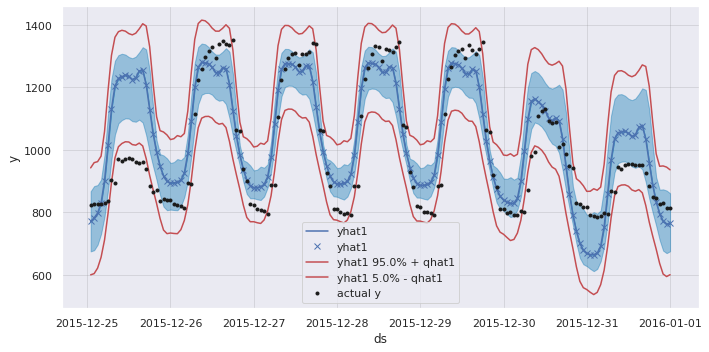

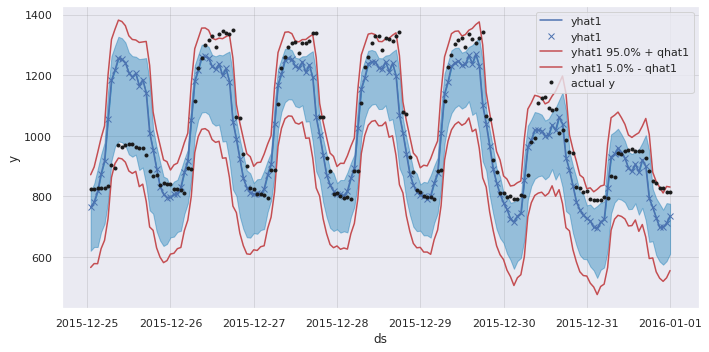

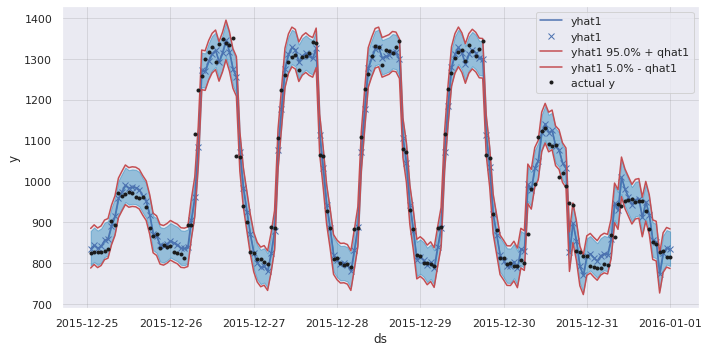

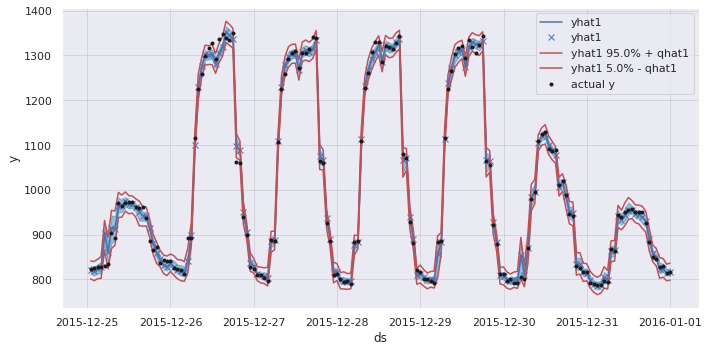

In [47]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend
)

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [48]:
conformal_methods = ["naive", "cqr"]
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ["interval_width", "miscoverage_rate"]]))
eval_df = eval_df.reset_index().rename(columns={"index": "model"})

Enter in the model names

In [49]:
eval_df["model"] = ["m1", "m2", "m3", "m4"]

Enter in the **interval_width** (*efficiency* metric)

In [50]:
# Naive interval width
naive_iw = [naive_qhat1 * 2, naive_qhat2 * 2, naive_qhat3 * 2, naive_qhat4 * 2]
eval_df["naive", "interval_width"] = naive_iw

In [51]:
# Calculate CQR interval width function
def calc_cqr_iw(fcast_df, qr_lo, qr_hi, qhat):
    qr_lo_mean = fcast_df["yhat1"].mean() - fcast_df[f"yhat1 {qr_lo}%"].mean()
    qr_hi_mean = fcast_df[f"yhat1 {qr_hi}%"].mean() - fcast_df["yhat1"].mean()
    return qr_lo_mean + qr_hi_mean + qhat * 2

In [52]:
# Quantile low/high values in string (%) format
quantile_lo_str = str(quantile_lo * 100)
quantile_hi_str = str(quantile_hi * 100)

In [53]:
# CQR interval width
cqr_iw1 = calc_cqr_iw(cqr_forecast1, quantile_lo_str, quantile_hi_str, cqr_qhat1)
cqr_iw2 = calc_cqr_iw(cqr_forecast2, quantile_lo_str, quantile_hi_str, cqr_qhat2)
cqr_iw3 = calc_cqr_iw(cqr_forecast3, quantile_lo_str, quantile_hi_str, cqr_qhat3)
cqr_iw4 = calc_cqr_iw(cqr_forecast4, quantile_lo_str, quantile_hi_str, cqr_qhat4)

cqr_iw = [cqr_iw1, cqr_iw2, cqr_iw3, cqr_iw4]
eval_df["cqr", "interval_width"] = cqr_iw

Enter in the **miscoverage rate** (*validity* metric)

In [54]:
# Calculate Naive miscoverage rate function
def calc_naive_mr(fcast_df):
    n_covered = fcast_df.apply(lambda row: bool(row["yhat1 - qhat1"] <= row["y"] <= row["yhat1 + qhat1"]), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [55]:
# Naive miscoverage rate
naive_mr1 = calc_naive_mr(naive_forecast1)
naive_mr2 = calc_naive_mr(naive_forecast2)
naive_mr3 = calc_naive_mr(naive_forecast3)
naive_mr4 = calc_naive_mr(naive_forecast4)

naive_mr = [naive_mr1, naive_mr2, naive_mr3, naive_mr4]
eval_df["naive", "miscoverage_rate"] = naive_mr

In [56]:
# Calculate CQR and CQR Advanced miscoverage rate function
def calc_cqr_mr(fcast_df, qr_lo, qr_hi):
    n_covered = fcast_df.apply(
        lambda row: bool(row[f"yhat1 {qr_lo}% - qhat1"] <= row["y"] <= row[f"yhat1 {qr_hi}% + qhat1"]), axis=1
    )
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [57]:
# CQR miscoverage rate
cqr_mr1 = calc_cqr_mr(cqr_forecast1, quantile_lo_str, quantile_hi_str)
cqr_mr2 = calc_cqr_mr(cqr_forecast2, quantile_lo_str, quantile_hi_str)
cqr_mr3 = calc_cqr_mr(cqr_forecast3, quantile_lo_str, quantile_hi_str)
cqr_mr4 = calc_cqr_mr(cqr_forecast4, quantile_lo_str, quantile_hi_str)

cqr_mr = [cqr_mr1, cqr_mr2, cqr_mr3, cqr_mr4]
eval_df["cqr", "miscoverage_rate"] = cqr_mr

Show evaluation dataframe

In [58]:
eval_df

model          naive                             cqr                 
        interval_width miscoverage_rate interval_width miscoverage_rate
0    m1     321.510601         0.111579     304.167136         0.111579
1    m2     260.608745         0.120000     325.856350         0.126316
2    m3      98.110261         0.090526      97.042411         0.092632
3    m4      43.317302         0.077895      44.818693         0.071579

**Summary**:

- The more complex the model m1->m4, the more accurate it is, hence the lower *interval width* and *miscoverage rate* metrics. The weaker models m1 and m2 have *miscoverage rate* above *alpha* of 0.1 while the stronger NN models m3 and m4 have *miscoverage rate* below *alpha*.
- For default model m1, CQR outputs narrower prediction *interval width* than Naive while maintaining the same *miscoverage rate*.
- However, for biased seasonality model m2,the Naive method has a narrower prediction *interval width* with a slightly better *miscoverage rate* than CQR.
- For complex m3 and m4 models, Naive and CQR methods have comparable *interval_width* and *miscoverage rate*. More testing needs to be done in order to determine which method is preferable to the other under which circumstances.